In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import shutil
import random

# Set seed for reproducibility
random.seed(42)

# Paths
original_dataset_dir = '/content/drive/MyDrive/Mammogram'
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# Create new directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Categories
categories = ['Benign', 'Malignant']

for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

    category_dir = os.path.join(original_dataset_dir, category)
    images = os.listdir(category_dir)
    random.shuffle(images)

    # Split the images into 80% training and 20% validation
    train_split = int(0.8 * len(images))
    train_images = images[:train_split]
    val_images = images[train_split:]

    for image in train_images:
        src = os.path.join(category_dir, image)
        dst = os.path.join(train_dir, category, image)
        shutil.copyfile(src, dst)

    for image in val_images:
        src = os.path.join(category_dir, image)
        dst = os.path.join(val_dir, category, image)
        shutil.copyfile(src, dst)

print("Dataset restructured successfully.")


In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for the validation set
val_datagen = ImageDataGenerator(rescale=1./255)

# Creating training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Creating validation data generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Check the class indices to make sure they are correctly mapped
print(train_generator.class_indices)
print(val_generator.class_indices)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
{'Benign': 0, 'Malignant': 1}
{'Benign': 0, 'Malignant': 1}


In [ ]:
# Print image counts for each class in training and validation sets
def count_images(directory):
    counts = {}
    for category in categories:
        category_dir = os.path.join(directory, category)
        counts[category] = len(os.listdir(category_dir))
    return counts

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)

print(f"Training set image counts: {train_counts}")
print(f"Validation set image counts: {val_counts}")

# Display some images from each class in the training set

Training set image counts: {'Benign': 4000, 'Malignant': 4000}
Validation set image counts: {'Benign': 1000, 'Malignant': 1000}


Benign images from training set:


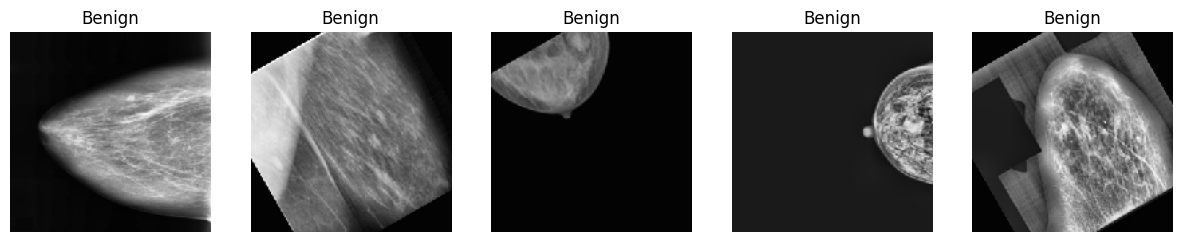

Malignant images from training set:


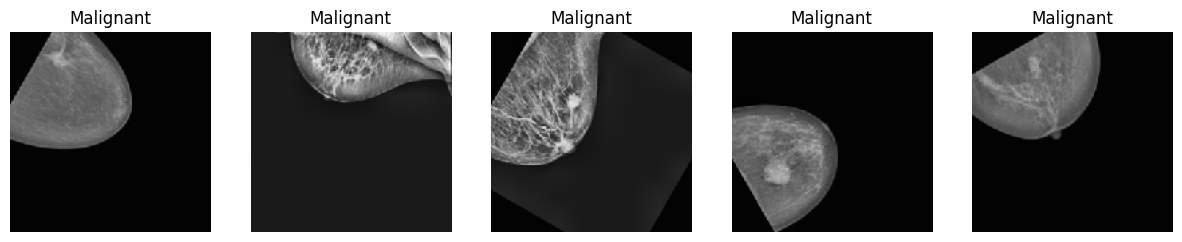

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

def display_images(generator, category, num_images=5):
    category_dir = os.path.join(train_dir, category)
    images = os.listdir(category_dir)[:num_images]
    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(images):
        image_path = os.path.join(category_dir, image_name)
        img = load_img(image_path, target_size=(150, 150))
        img_array = img_to_array(img) / 255.0
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()

print("Benign images from training set:")
display_images(train_generator, 'Benign')

print("Malignant images from training set:")
display_images(train_generator, 'Malignant')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/50
250/250 [==============================] - 66s 227ms/step - loss: 0.9470 - accuracy: 0.6453 - val_loss: 7.6780 - val_accuracy: 0.4995 - lr: 0.0010
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 56s 224ms/step - loss: 0.5378 - accuracy: 0.7140 - val_loss: 3.7764 - val_accuracy: 0.5872 - lr: 0.0010
Epoch 3/50
250/250 [==============================] - 56s 224ms/step - loss: 0.5099 - accuracy: 0.7303 - val_loss: 0.5279 - val_accuracy: 0.7228 - lr: 0.0010
Epoch 4/50
250/250 [==============================] - 56s 224ms/step - loss: 0.5133 - accuracy: 0.7360 - val_loss: 0.4781 - val_accuracy: 0.7510 - lr: 0.0010
Epoch 5/50
250/250 [==============================] - 57s 229ms/step - loss: 0.5150 - accuracy: 0.7251 - val_loss: 0.4650 - val_accuracy: 0.7550 - lr: 0.0010
Epoch 6/50
250/250 [==============================] - 56s 223ms/step - loss: 0.4878 - accuracy: 0.7408 - val_loss: 0.8385 - val_accuracy: 0.5685 - lr: 0.0010
Epoch 7/50
250/250 [==============================] - 56s 223ms/step - loss: 0.4913 - accuracy: 0.7414 - val_loss: 1.9519 - val_accuracy: 0.5212 - lr: 0.0010
Epoch 8/50
250/250 [==============================] - 56s 223ms

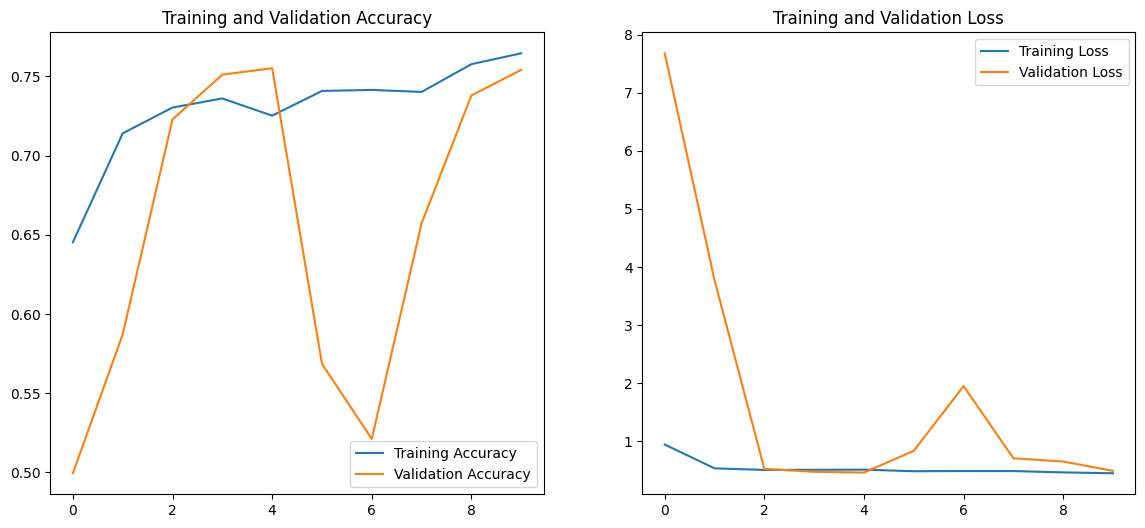

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

63/63 [==============================] - 3s 44ms/step
Confusion Matrix:
[[247 753]
 [272 728]]


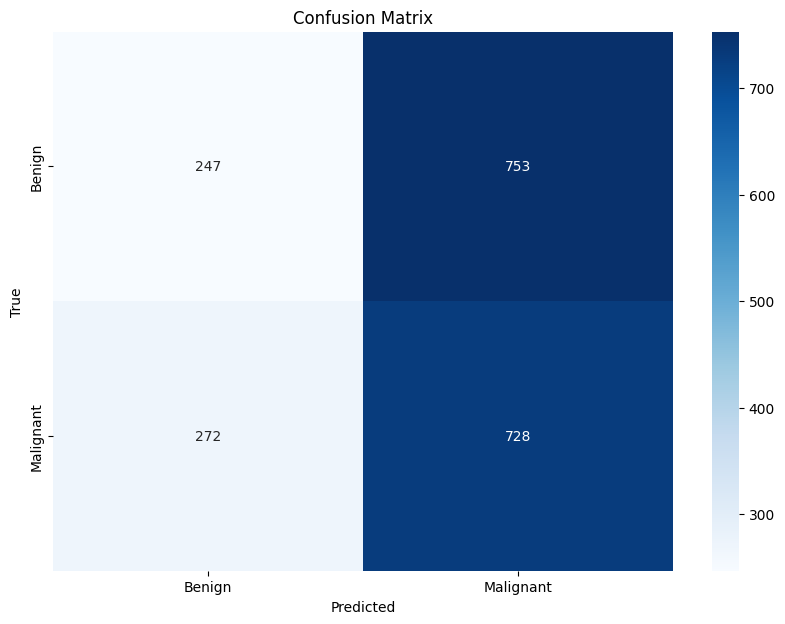

Classification Report:
              precision    recall  f1-score   support

      Benign       0.48      0.25      0.33      1000
   Malignant       0.49      0.73      0.59      1000

    accuracy                           0.49      2000
   macro avg       0.48      0.49      0.46      2000
weighted avg       0.48      0.49      0.46      2000



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get the ground truth labels and the predicted labels
val_generator.reset()
Y_pred = model.predict(val_generator, val_generator.samples // val_generator.batch_size + 1)
y_pred = np.round(Y_pred).astype(int).flatten()

# Get the true labels
y_true = val_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=categories))


Epoch 1/50
250/250 [==============================] - 60s 226ms/step - loss: 2.2303 - accuracy: 0.6489 - val_loss: 4.2643 - val_accuracy: 0.5000 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
250/250 [==============================] - 57s 229ms/step - loss: 1.4174 - accuracy: 0.7034 - val_loss: 1.3102 - val_accuracy: 0.7182 - lr: 0.0010
Epoch 3/50
250/250 [==============================] - 57s 230ms/step - loss: 1.1565 - accuracy: 0.7211 - val_loss: 1.0882 - val_accuracy: 0.7253 - lr: 0.0010
Epoch 4/50
250/250 [==============================] - 56s 224ms/step - loss: 0.9634 - accuracy: 0.7259 - val_loss: 0.9959 - val_accuracy: 0.6734 - lr: 0.0010
Epoch 5/50
250/250 [==============================] - 57s 228ms/step - loss: 0.8385 - accuracy: 0.7272 - val_loss: 1.0193 - val_accuracy: 0.5247 - lr: 0.0010
Epoch 6/50
250/250 [==============================] - 56s 225ms/step - loss: 0.7606 - accuracy: 0.7237 - val_loss: 1.1306 - val_accuracy: 0.5489 - lr: 0.0010
Epoch 7/50
250/250 [==============================] - 57s 227ms/step - loss: 0.6886 - accuracy: 0.7320 - val_loss: 0.8746 - val_accuracy: 0.5484 - lr: 0.0010
Epoch 8/50
250/250 [==============================] 

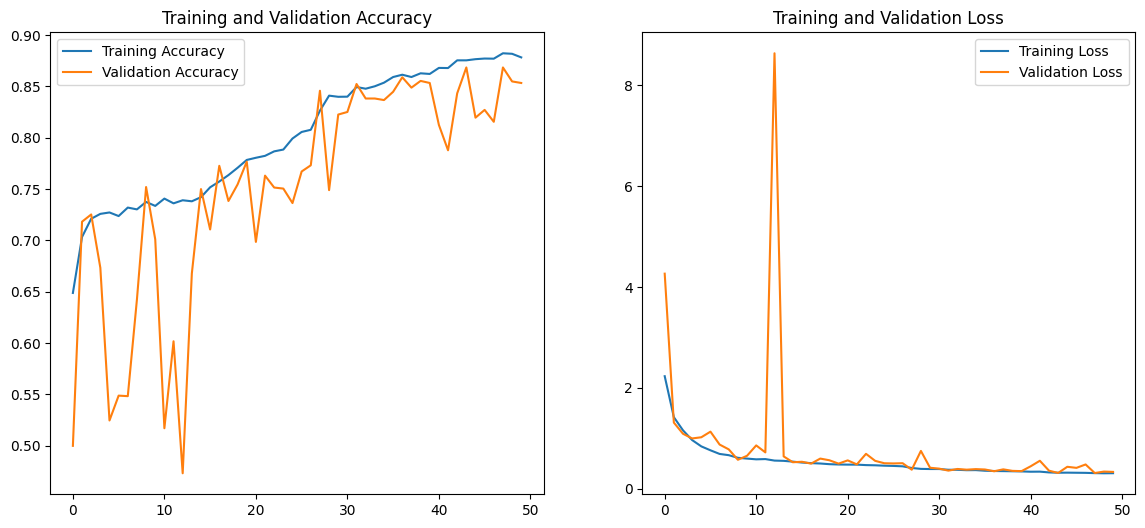

63/63 [==============================] - 4s 54ms/step
Confusion Matrix:
[[384 616]
 [358 642]]


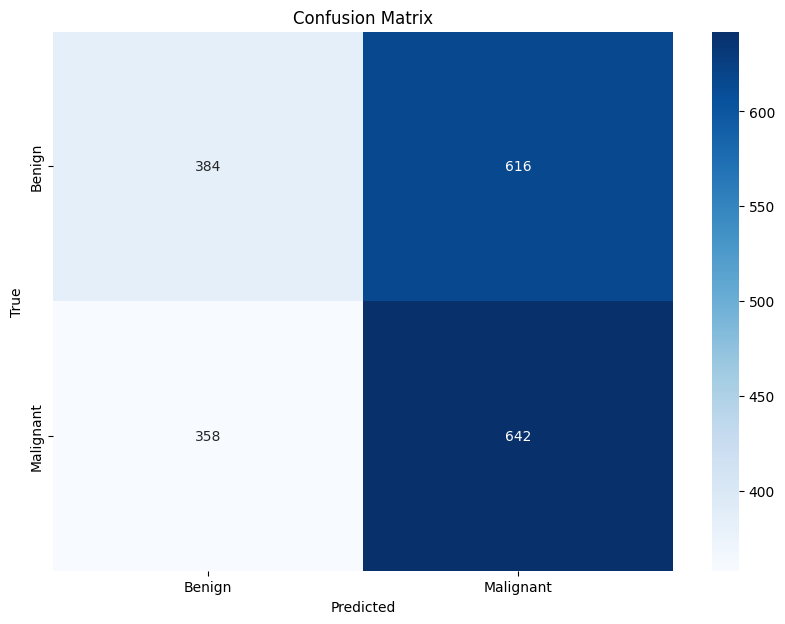

Classification Report:
              precision    recall  f1-score   support

      Benign       0.52      0.38      0.44      1000
   Malignant       0.51      0.64      0.57      1000

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.50      2000
weighted avg       0.51      0.51      0.50      2000



In [ ]:
from tensorflow.keras.regularizers import l2

# Define the model with L2 regularization added to convolutional layers
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks with adjusted patience for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model with a modified batch size if necessary
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

# Plot training and validation accuracy and loss
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get the ground truth labels and the predicted labels
val_generator.reset()
Y_pred = model.predict(val_generator, val_generator.samples // val_generator.batch_size + 1)
y_pred = np.round(Y_pred).astype(int).flatten()

# Get the true labels
y_true = val_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=categories))


